## 数据集的划分，将模型训练需要的数据获取到，将每个类别的前500张拿出来作为模型训练数据

In [1]:
import os
import shutil

# 设置主文件夹路径和目标文件夹路径
main_folder = '/Users/huangweijin/Downloads/test_data'
target_folder = '/Users/huangweijin/Downloads/题目一测试图片'
num_images_to_copy = 500

# 创建目标文件夹（如果不存在的话）
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# 获取主文件夹中所有类别文件夹的路径
categories = [d for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]

for category in categories:
    category_folder = os.path.join(main_folder, category)
    target_category_folder = os.path.join(target_folder, category)

    # 创建目标类别文件夹（如果不存在的话）
    if not os.path.exists(target_category_folder):
        os.makedirs(target_category_folder)

    # 获取类别文件夹中的所有图片文件，并按文件名排序
    images = [f for f in os.listdir(category_folder) if os.path.isfile(os.path.join(category_folder, f))]
    images.sort()  # 对文件名进行排序

    # 选择前 num_images_to_copy 张图片
    selected_images = images[:min(num_images_to_copy, len(images))]

    # 复制选定的图片到目标类别文件夹
    for image in selected_images:
        src_path = os.path.join(category_folder, image)
        dst_path = os.path.join(target_category_folder, image)
        shutil.copy(src_path, dst_path)

print("图片复制完成！")


图片复制完成！


## 将拿到的数据集进行划分，得到模型训练需要的训练集和验证集数据及数据加载器

Random Training Images per Class:


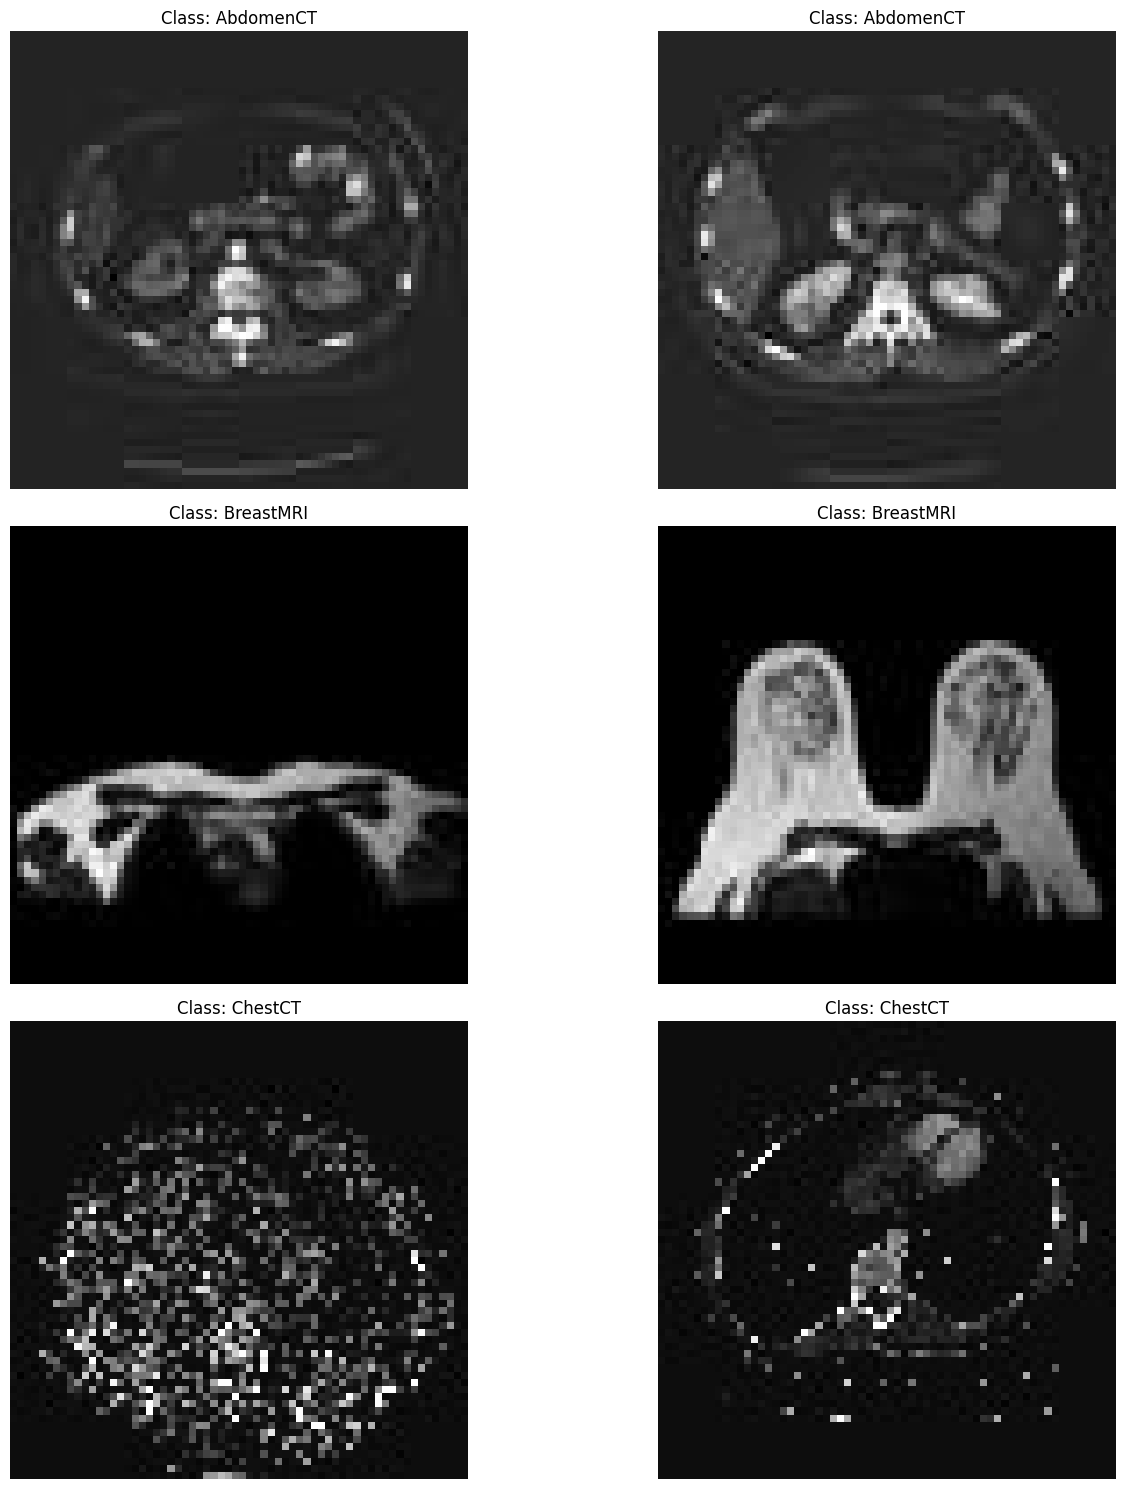

Random Validation Images per Class:


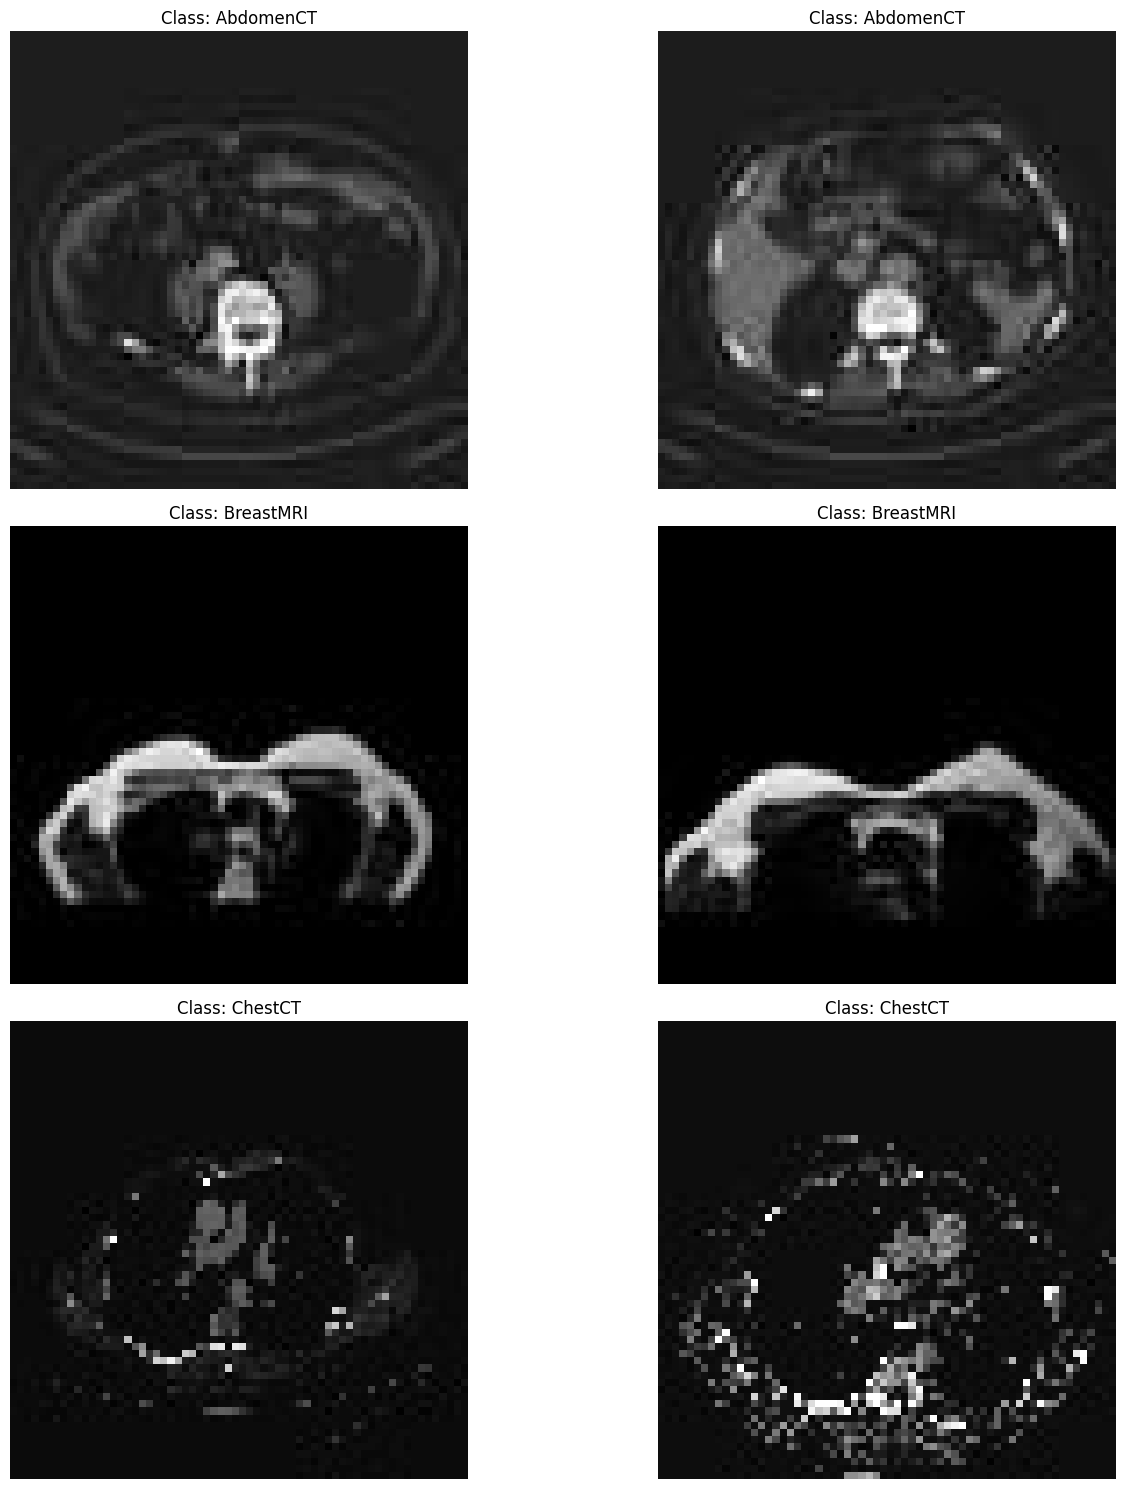

In [3]:
import torch
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image

# 设置随机种子，以确保结果的可重复性
torch.manual_seed(40)

# 定义数据路径
data_dir = '/Users/huangweijin/Downloads/题目一测试图片'

# 定义图像大小和批次大小
img_size = (64, 64)
batch_size = 64

# 数据预处理
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.Grayscale(num_output_channels=1),  # 转换为单通道
    transforms.ToTensor(),
])

# 加载数据集
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 数据集划分为训练集和测试集
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 随机显示每个类别中的两张图片
def show_images_per_class(data_loader, dataset, num_images_per_class=2):
    class_indices = {i: [] for i in range(len(dataset.classes))}
    
    # 收集每个类别的图片索引
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    fig, axes = plt.subplots(len(dataset.classes), num_images_per_class, figsize=(15, 5 * len(dataset.classes)))
    
    # 随机选择并显示每个类别的图片
    for class_idx, indices in class_indices.items():
        selected_indices = random.sample(indices, num_images_per_class)
        for img_idx, ax in zip(selected_indices, axes[class_idx]):
            img, label = dataset[img_idx]
            ax.imshow(img.squeeze(0), cmap='gray')
            ax.set_title(f'Class: {dataset.classes[label]}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 显示训练集每个类别的图片
print("Random Training Images per Class:")
show_images_per_class(train_loader, dataset)

# 显示验证集每个类别的图片
print("Random Validation Images per Class:")
show_images_per_class(test_loader, dataset)


## 建立一个简单的卷积神经网络来对图片进行分类

In [4]:
import torch.nn as nn
import torch.optim as optim
# 定义CNN模型
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):#在目标文件里面的分类类别数目为3类
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 输入通道改为1
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * (img_size[0] // 4) * (img_size[1] // 4), 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 初始化模型、损失函数和优化器
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 模型训练过程指标的保存和指标绘制

In [5]:
import time
# 定义空列表来存储每个 epoch 的损失、训练准确度和验证准确度
losses = []
train_accuracies = []
valid_accuracies = []
valid_losses = []

# 训练模型
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 获取训练集和验证集的图片数量
num_train_images = len(train_dataset)
num_valid_images = len(test_dataset)
print(f'Training images: {num_train_images}, Validation images: {num_valid_images}')
# 记录开始时间
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # 验证模型
    model.eval()
    correct_valid = 0
    total_valid = 0
    valid_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    losses.append(epoch_loss / len(train_loader))
    valid_losses.append(valid_loss / len(test_loader))

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}, '
          f'Validation Loss: {valid_loss / len(test_loader):.4f}')
# 记录结束时间
end_time = time.time()
training_time = end_time - start_time
print(f'Total training time: {training_time:.2f} seconds')

Training images: 1050, Validation images: 450
Epoch [1/30], Loss: 0.6116, Train Accuracy: 0.7210, Validation Accuracy: 1.0000, Validation Loss: 0.1416
Epoch [2/30], Loss: 0.0705, Train Accuracy: 0.9924, Validation Accuracy: 1.0000, Validation Loss: 0.0032
Epoch [3/30], Loss: 0.0085, Train Accuracy: 0.9990, Validation Accuracy: 1.0000, Validation Loss: 0.0002
Epoch [4/30], Loss: 0.0023, Train Accuracy: 1.0000, Validation Accuracy: 1.0000, Validation Loss: 0.0001
Epoch [5/30], Loss: 0.0014, Train Accuracy: 1.0000, Validation Accuracy: 1.0000, Validation Loss: 0.0000
Epoch [6/30], Loss: 0.0007, Train Accuracy: 1.0000, Validation Accuracy: 1.0000, Validation Loss: 0.0000
Epoch [7/30], Loss: 0.0010, Train Accuracy: 1.0000, Validation Accuracy: 1.0000, Validation Loss: 0.0000
Epoch [8/30], Loss: 0.0005, Train Accuracy: 1.0000, Validation Accuracy: 1.0000, Validation Loss: 0.0000
Epoch [9/30], Loss: 0.0002, Train Accuracy: 1.0000, Validation Accuracy: 1.0000, Validation Loss: 0.0000
Epoch [10

## 绘制出训练Loss、Accuracy指标

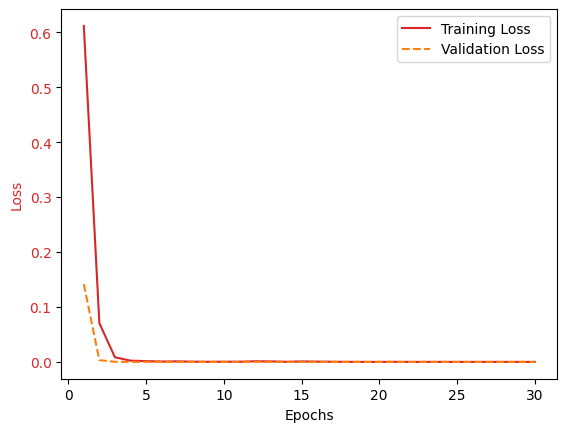

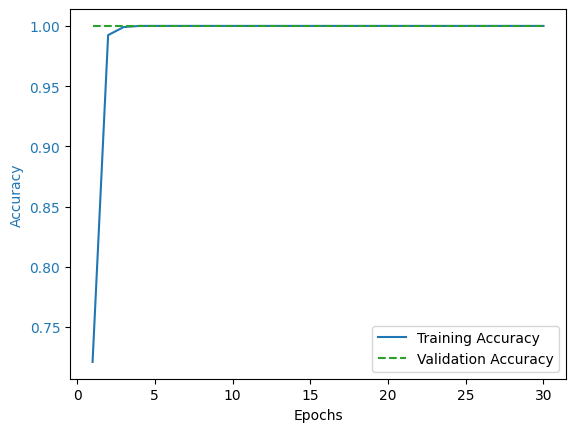

In [10]:
# 绘制训练损失和验证损失
fig, ax1 = plt.subplots()
color_loss = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color_loss)
ax1.plot(range(1, num_epochs + 1), losses, label='Training Loss', color=color_loss)
ax1.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss', linestyle='dashed', color='tab:orange')
ax1.tick_params(axis='y', labelcolor=color_loss)
ax1.legend(loc="upper right")

# 创建第二个图表用于绘制训练准确度和验证准确度
fig, ax2 = plt.subplots()
color_acc = 'tab:blue'
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy', color=color_acc)
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color=color_acc)
ax2.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy', linestyle='dashed', color='tab:green')
ax2.tick_params(axis='y', labelcolor=color_acc)
ax2.legend(loc="lower right")

plt.show()

## 保存训练的模型权重，命名为simple_cnn_model.pth

In [11]:

# 保存模型
model_path = '/Users/huangweijin/Downloads/test_data/simple_cnn_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to /Users/huangweijin/Downloads/test_data/simple_cnn_model.pth


## 计算出模型的其他指标

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
# 在测试集上评估模型
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 生成混淆矩阵和分类报告
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[138   0   0]
 [  0 162   0]
 [  0   0 150]]
Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00       138
   BreastMRI       1.00      1.00      1.00       162
     ChestCT       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



## 模型的实际预测

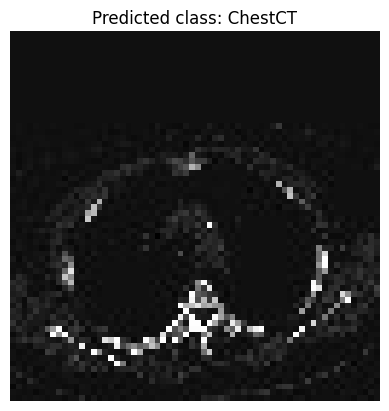

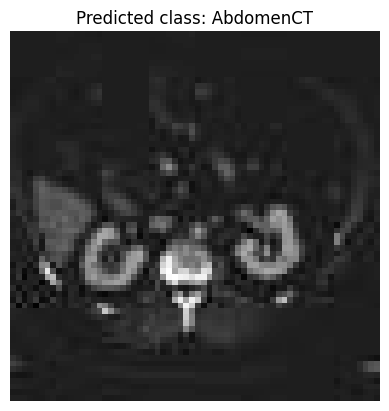

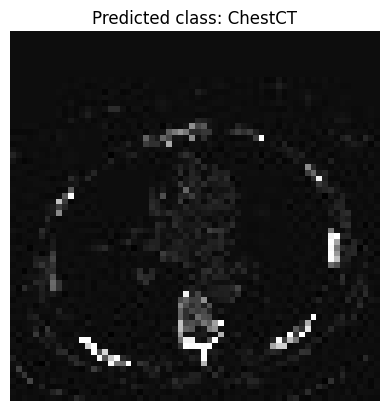

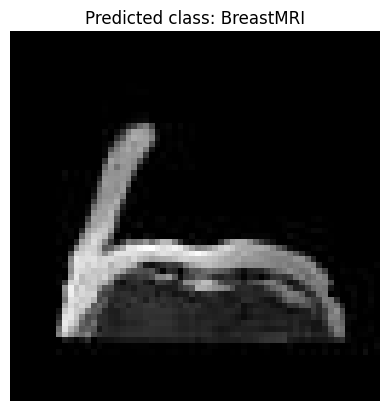

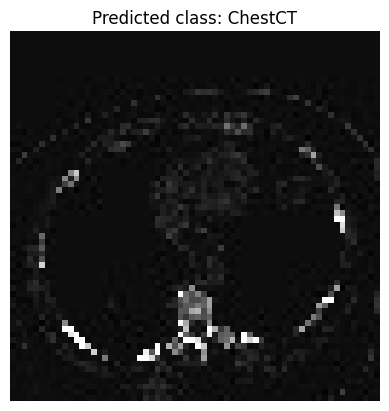

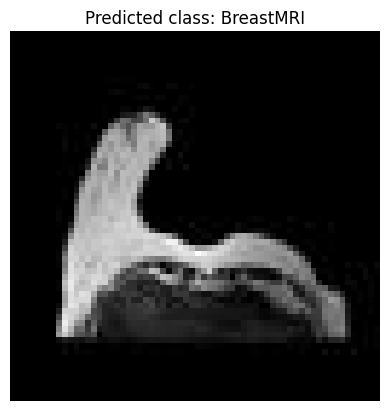

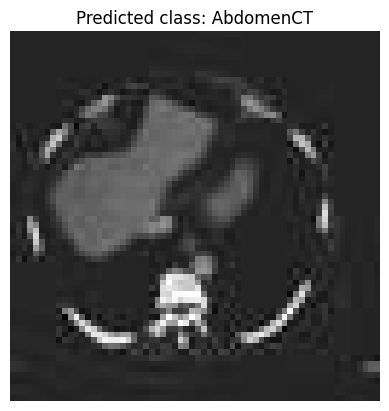

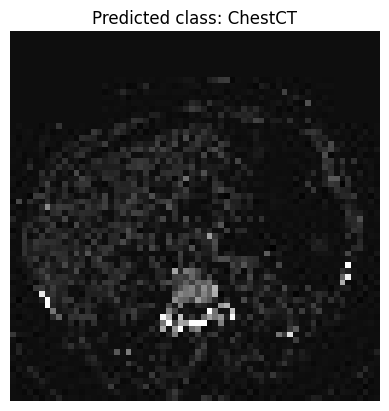

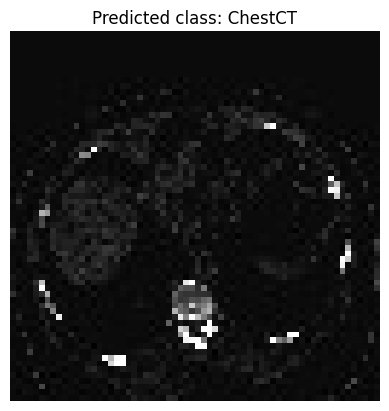

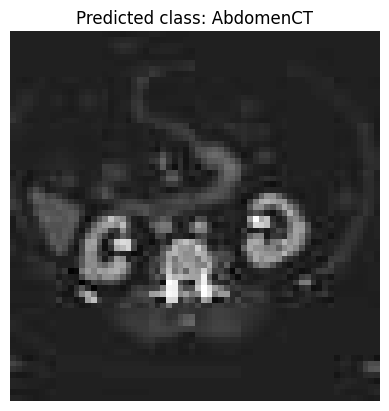

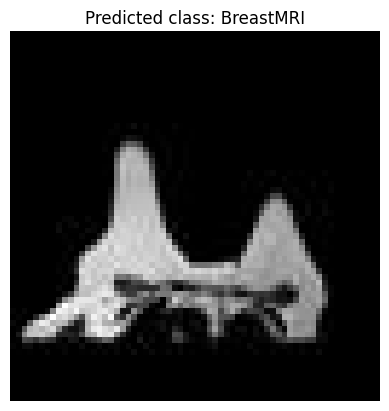

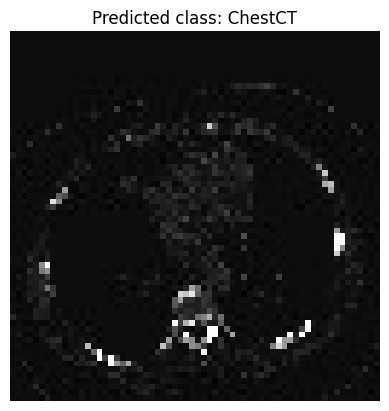

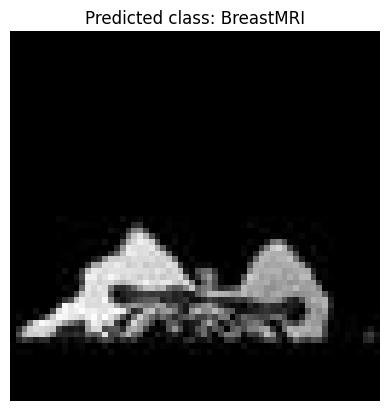

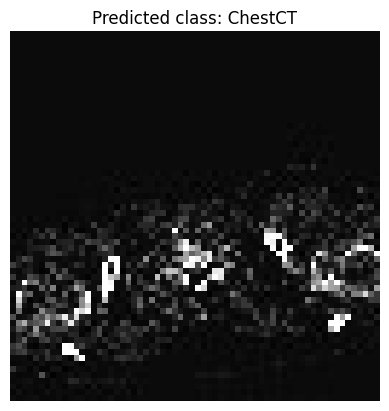

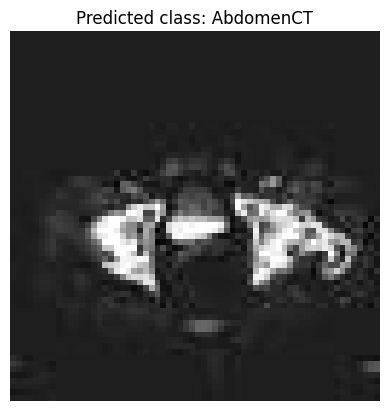

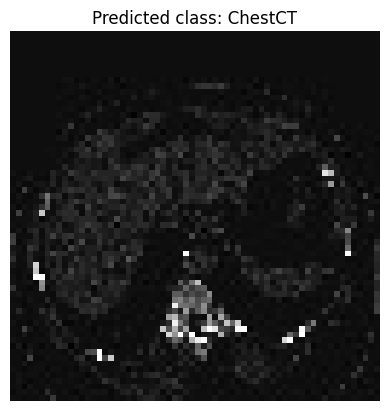

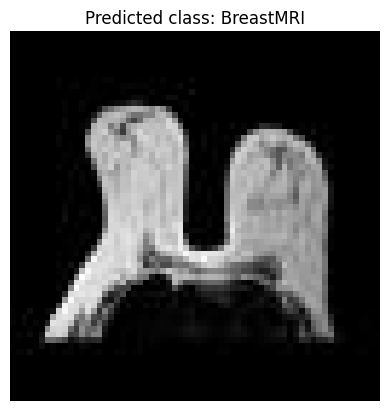

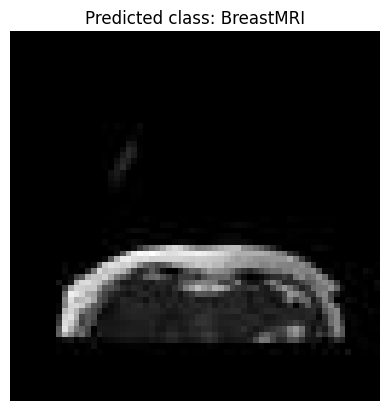

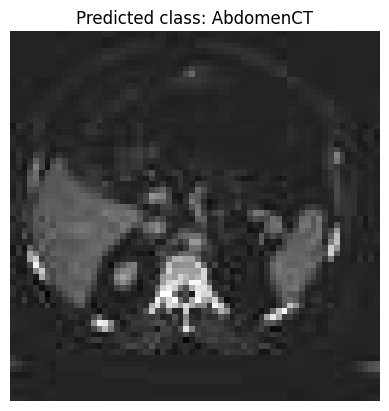

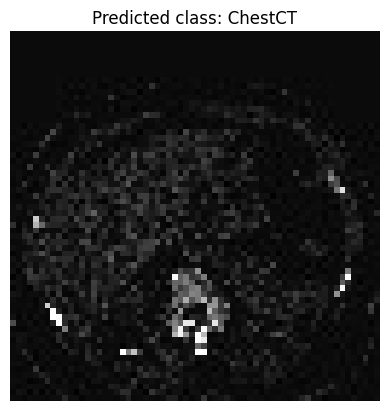

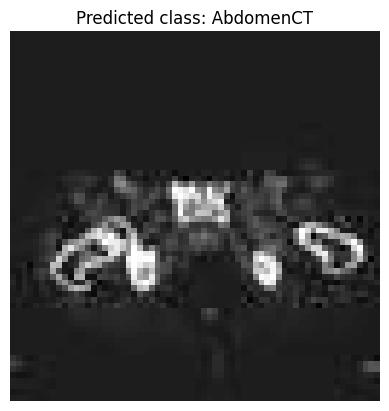

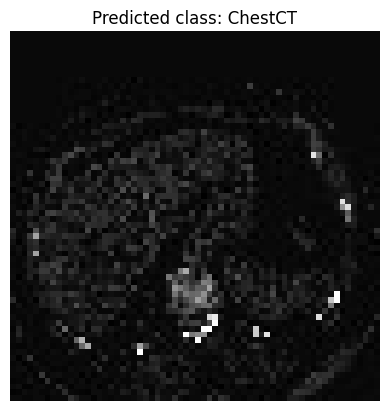

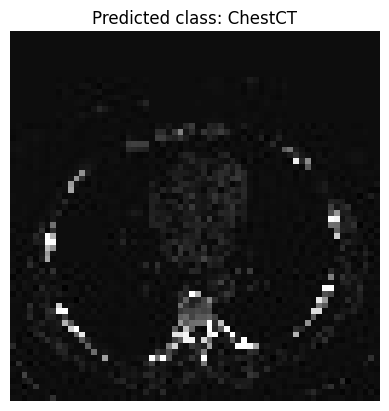

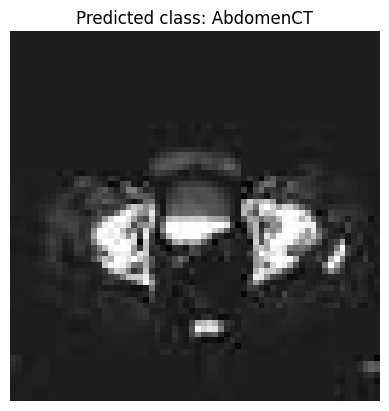

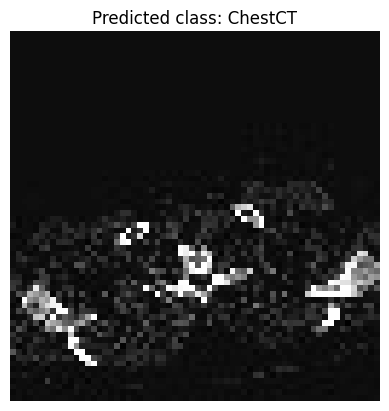

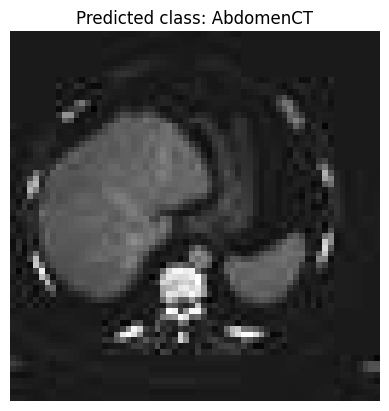

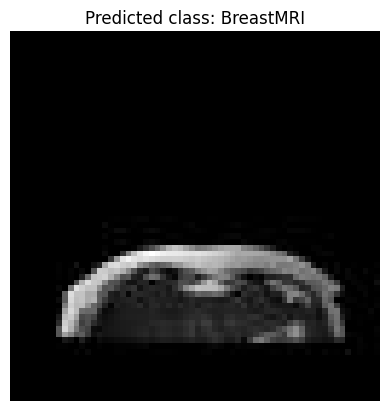

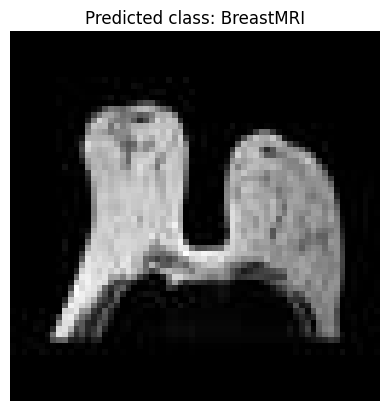

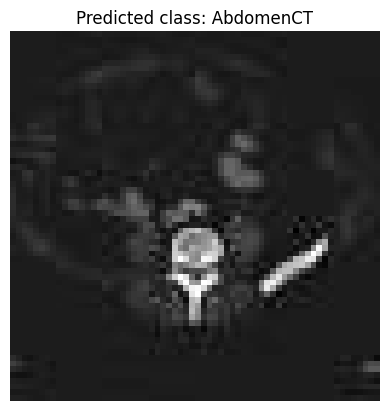

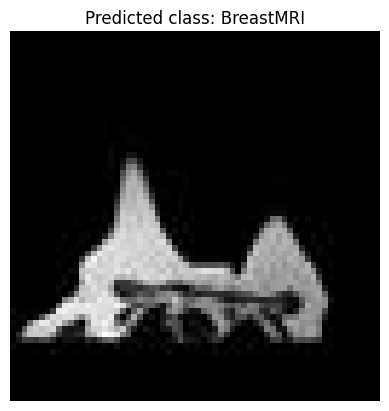

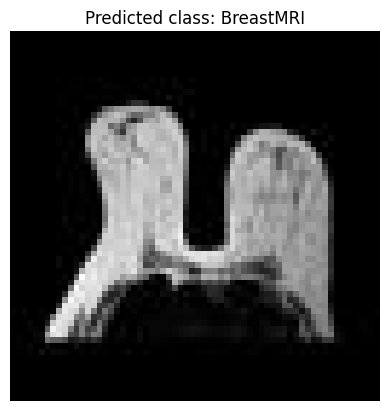

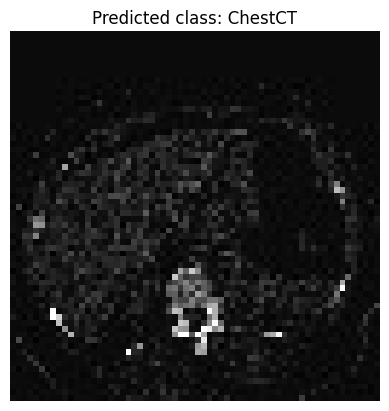

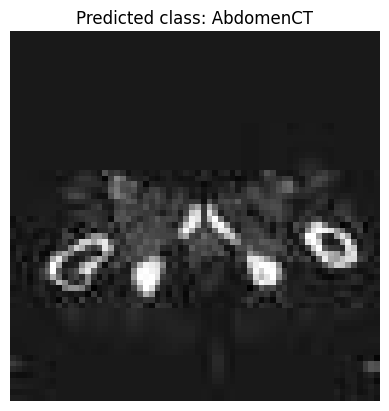

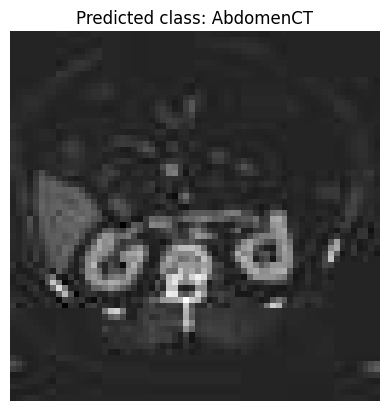

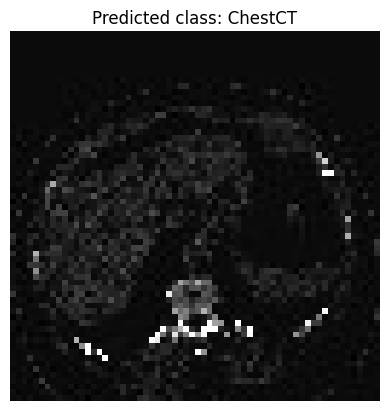

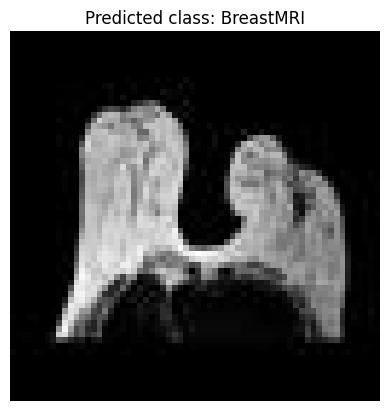

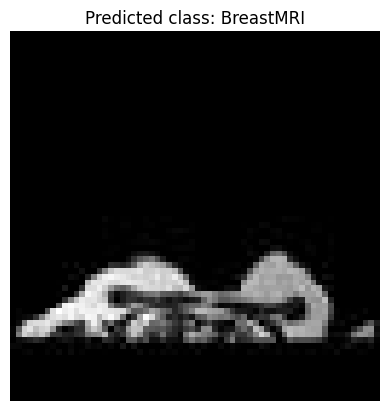

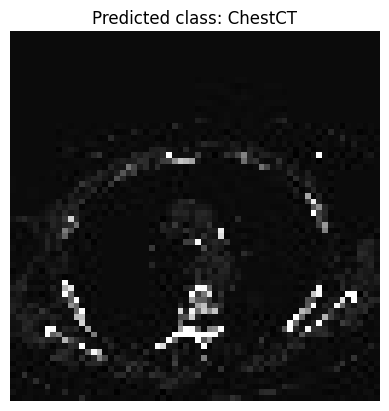

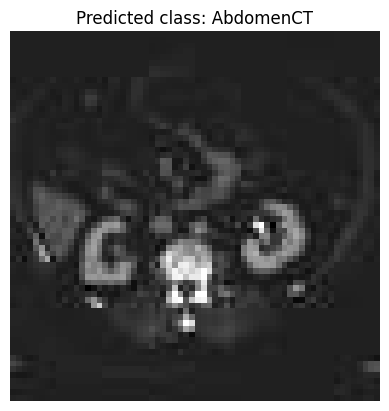

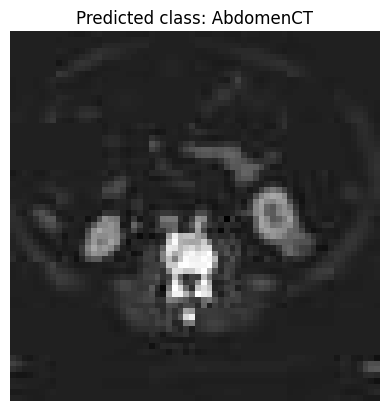

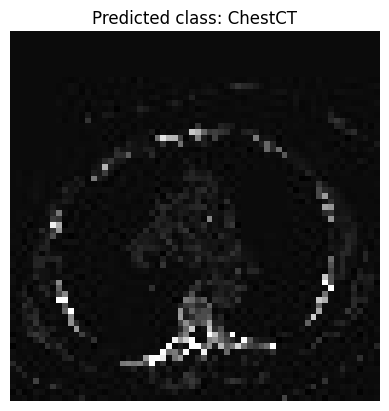

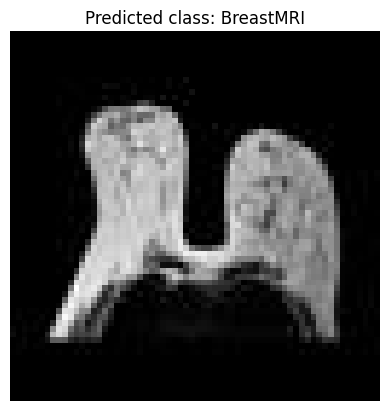

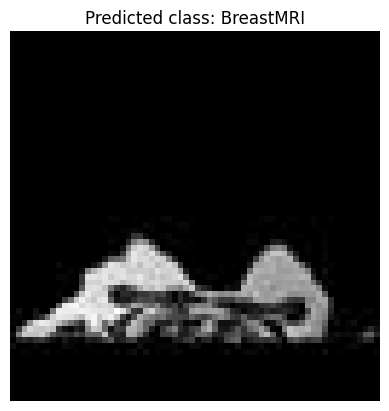

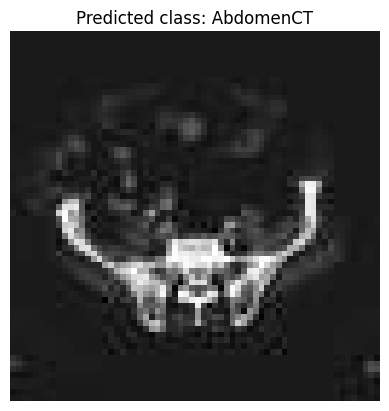

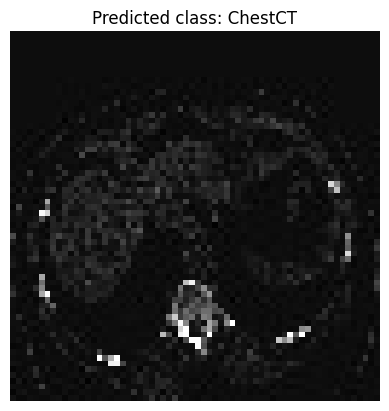

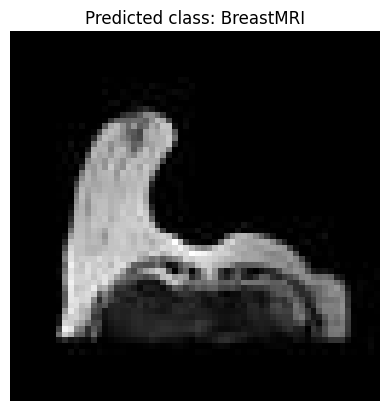

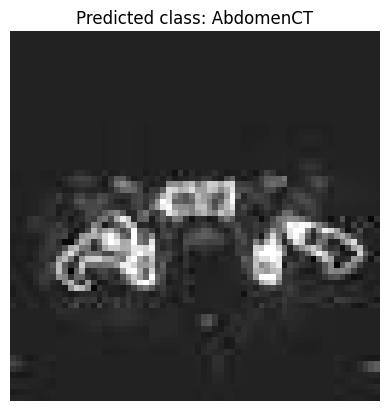

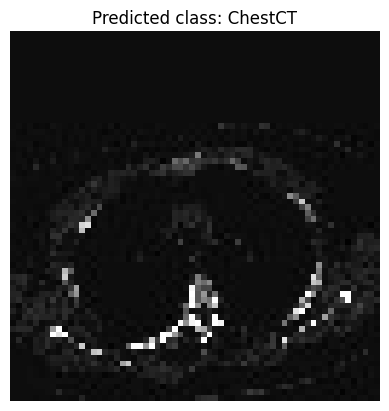

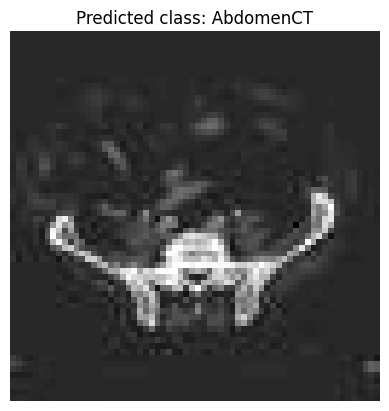

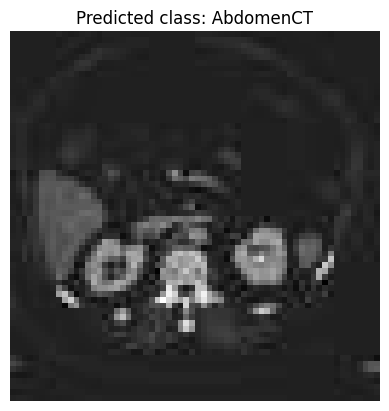

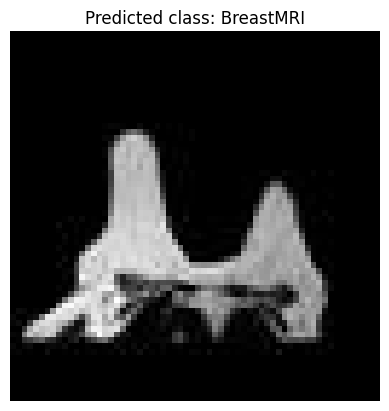

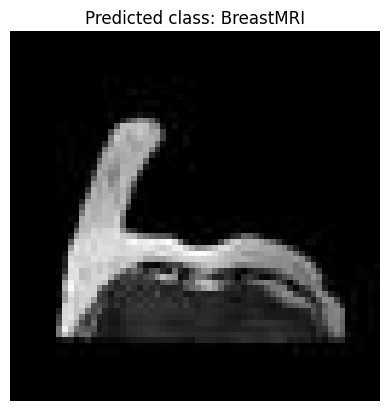

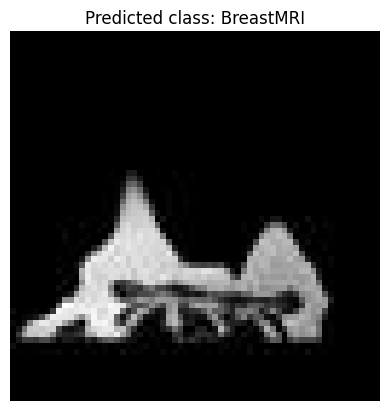

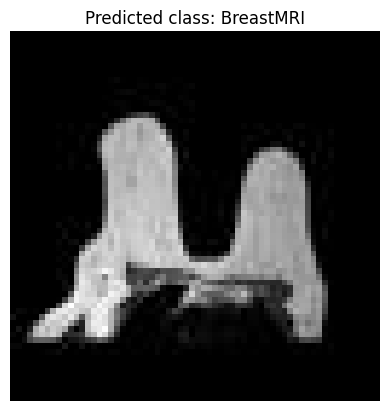

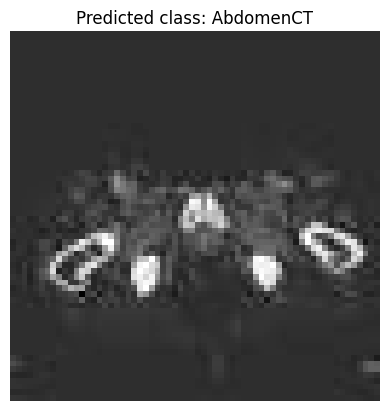

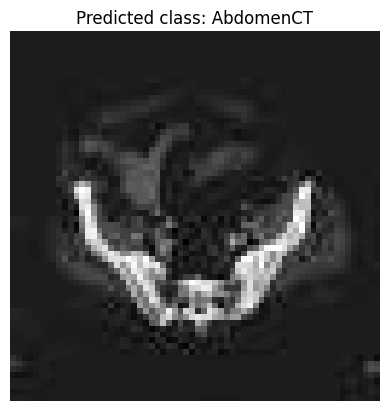

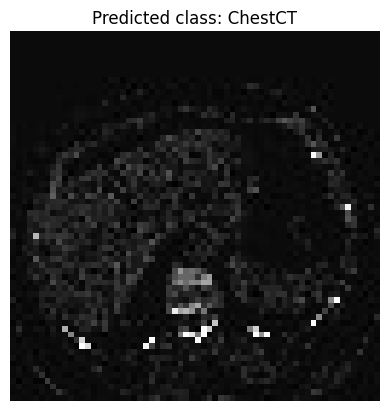

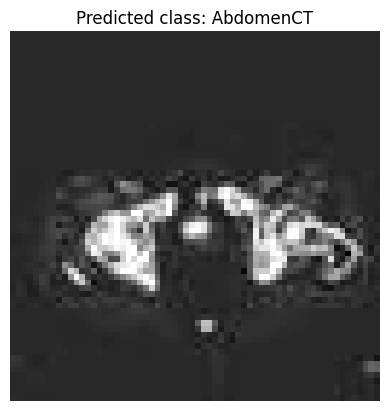

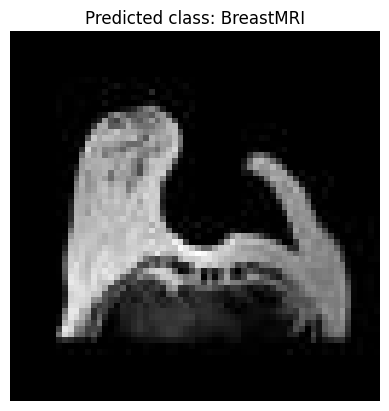

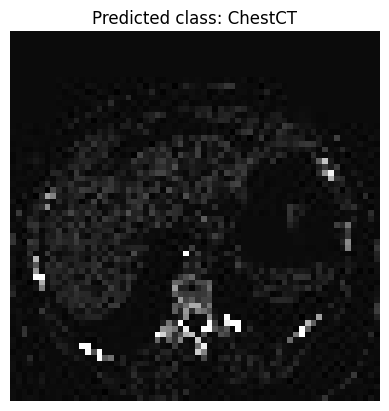

In [13]:
# 定义模型并加载权重
model_path = '/Users/huangweijin/Downloads/test_data/simple_cnn_model.pth'
model = SimpleCNN()  
model.load_state_dict(torch.load(model_path))
model.to(device) 

# 模型预测
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('L')  # 转换为灰度图
    image = transform(image)
    image = image.unsqueeze(0)  # 增加一个维度
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    return dataset.classes[predicted_class.item()]

def predict_images_folder(folder_path, model, transform):
    predictions = []
    image_paths = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_path = os.path.join(folder_path, filename)
            image_paths.append(image_path)

            predicted_class = predict_image(image_path, model, transform)
            predictions.append((image_path, predicted_class))

    return predictions

# 使用 predict_images_folder 函数
batch_predict_folder = '/Users/huangweijin/Downloads/题目一模型验证图片'
batch_predictions = predict_images_folder(batch_predict_folder, model, transform)

# 显示每张图像的预测结果
for image_path, prediction in batch_predictions:
    img = Image.open(image_path)
    plt.imshow(img, cmap='gray')  # 显示为灰度图
    plt.title(f'Predicted class: {prediction}')
    plt.axis('off')
    plt.show()


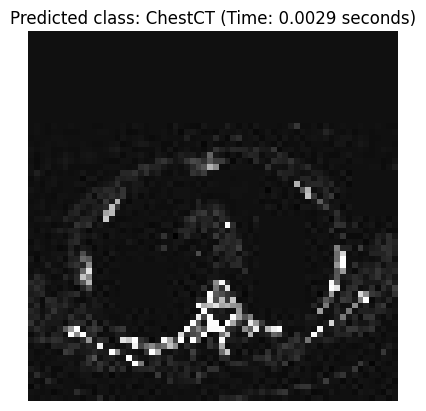

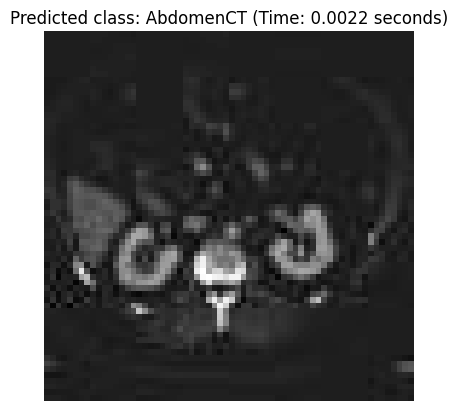

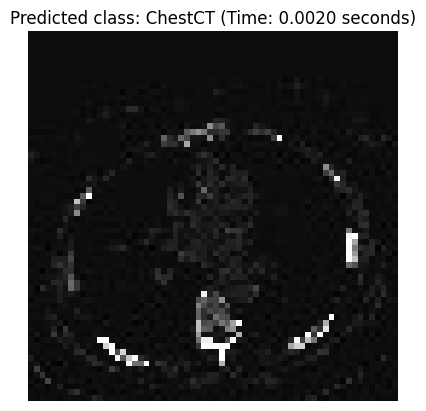

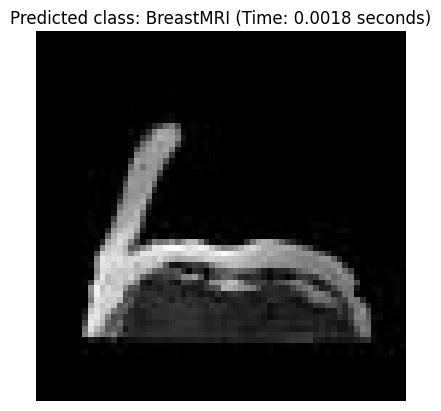

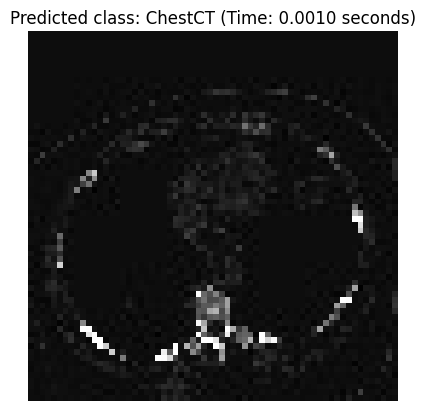

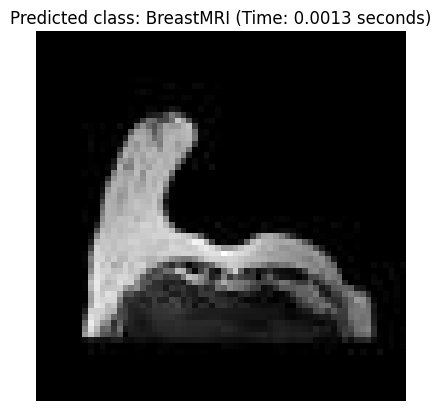

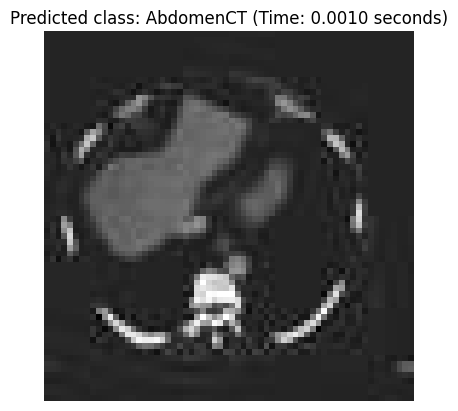

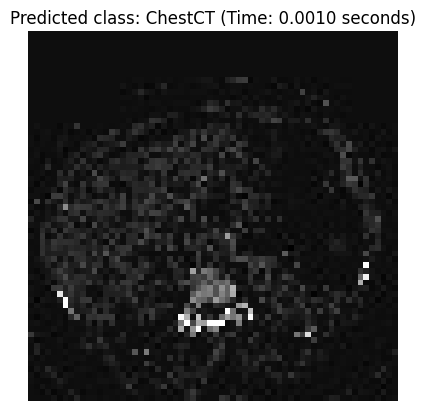

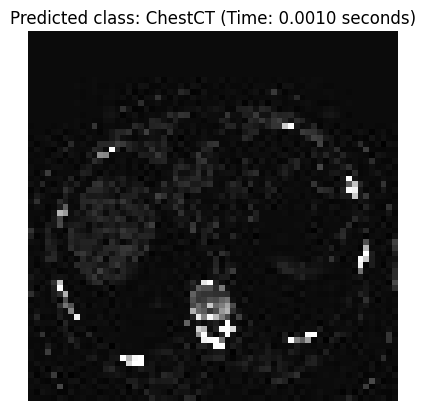

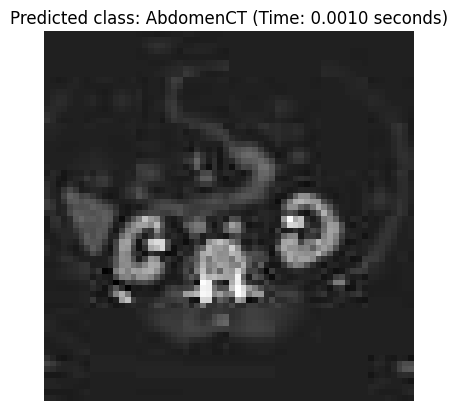

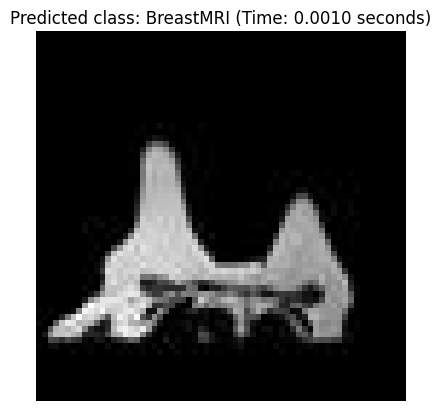

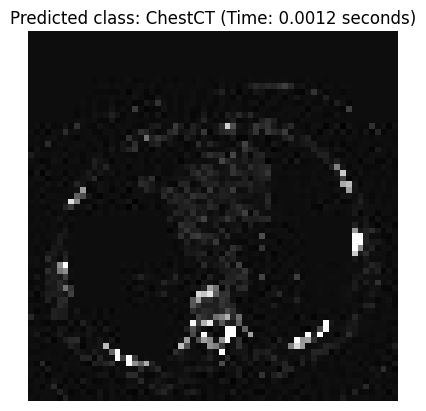

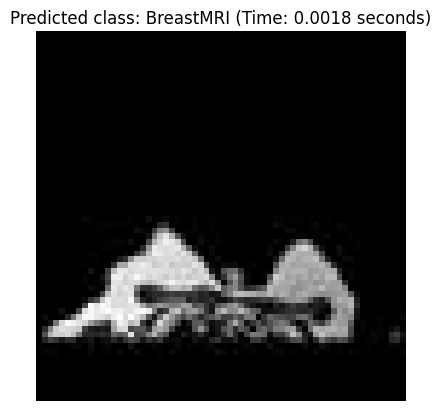

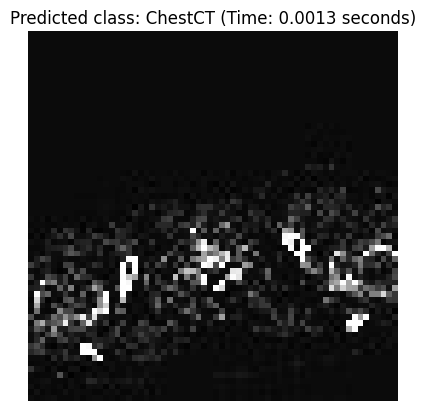

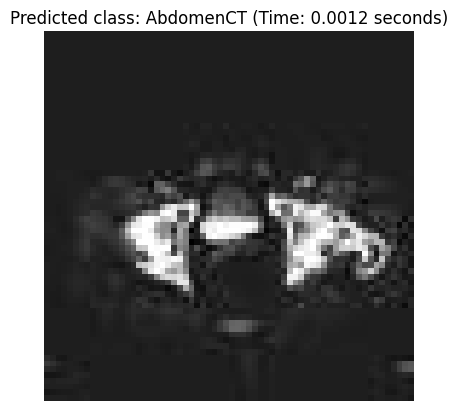

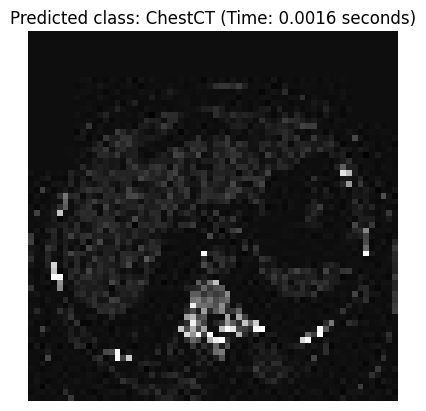

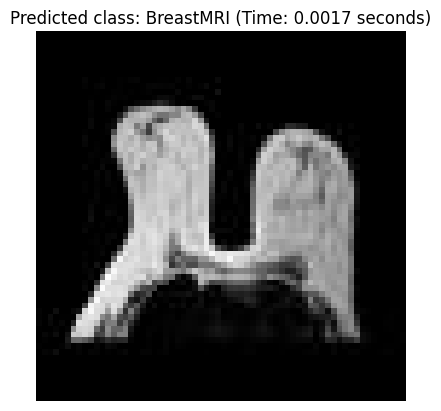

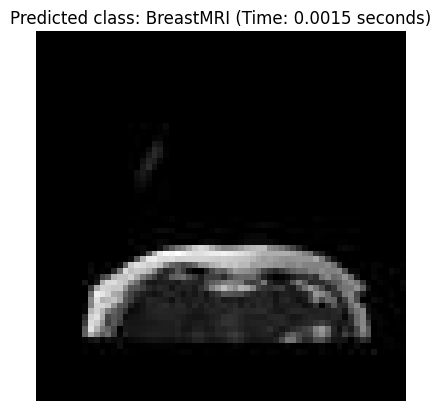

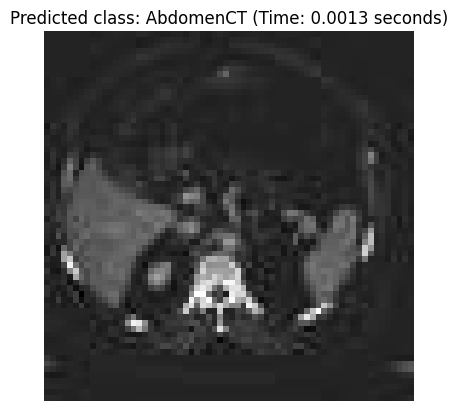

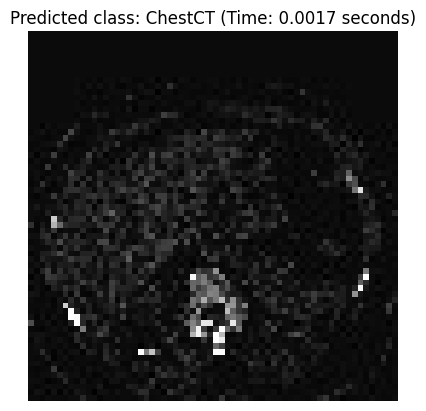

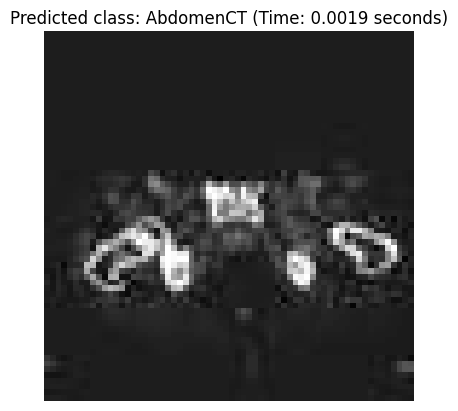

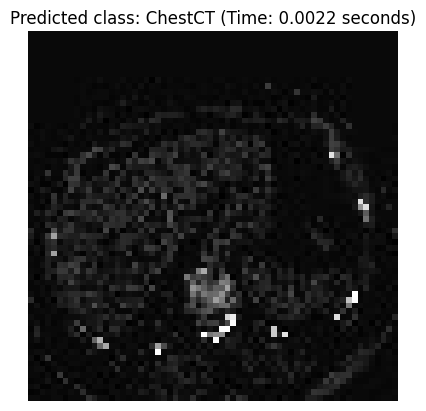

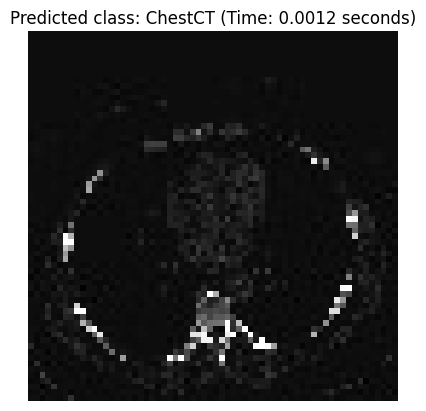

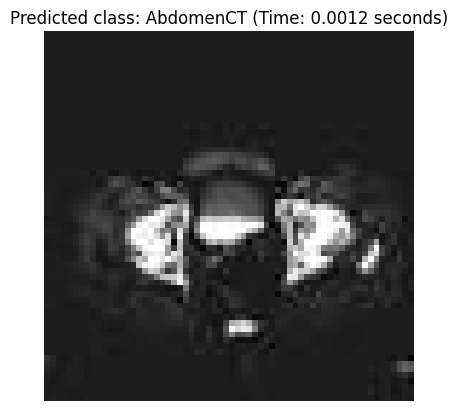

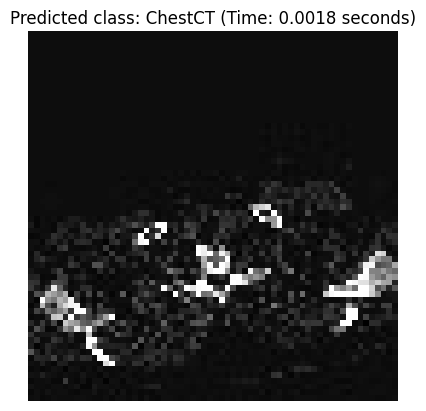

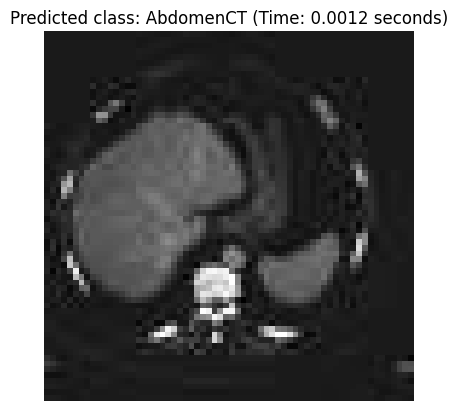

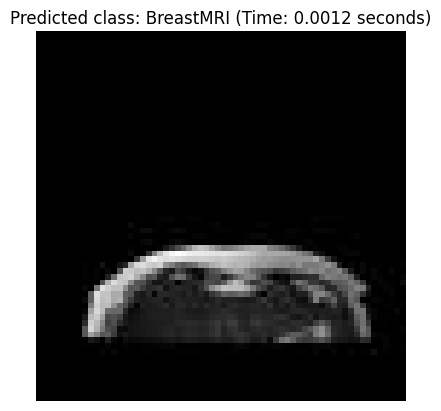

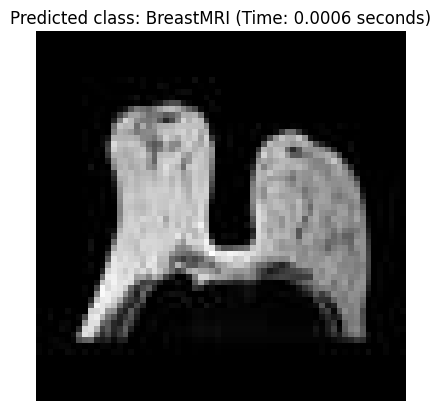

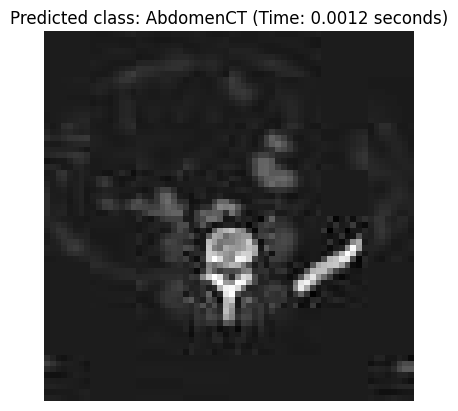

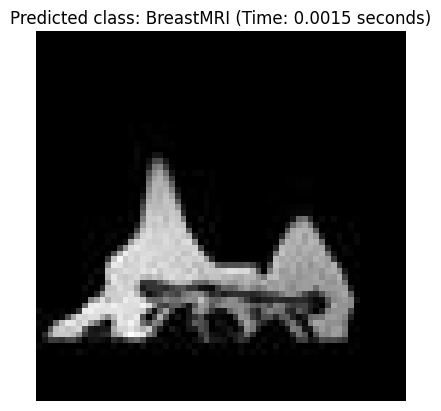

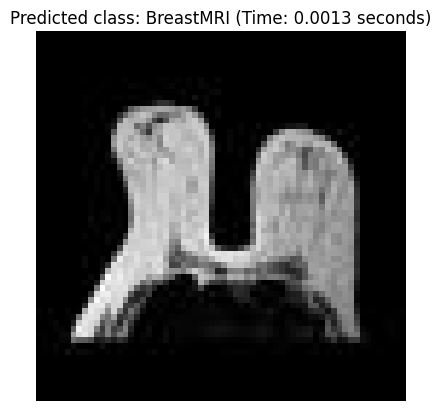

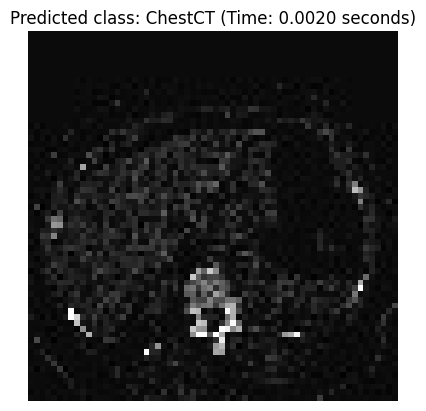

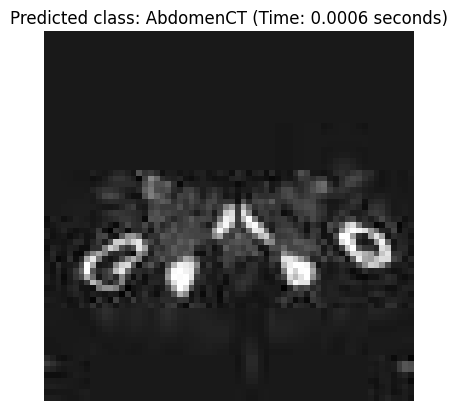

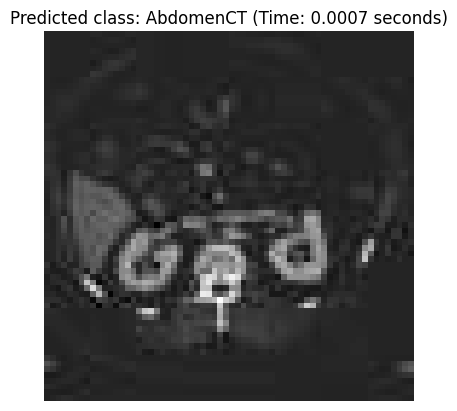

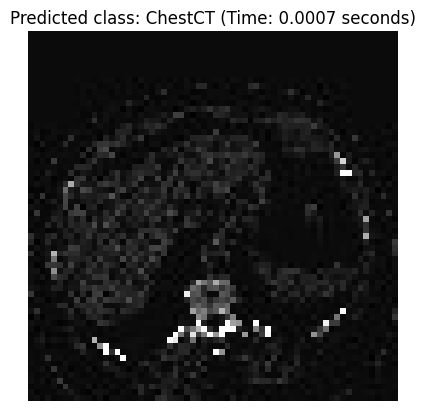

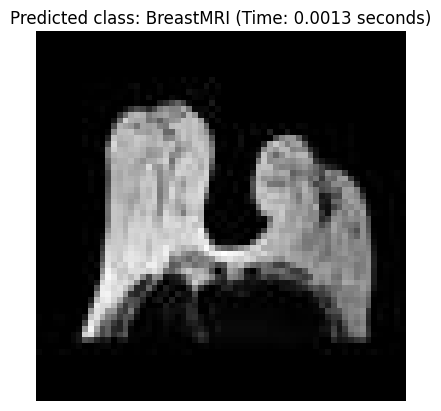

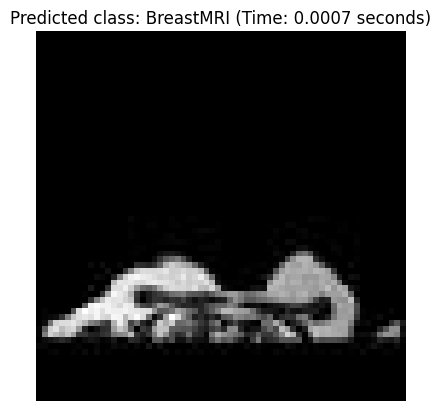

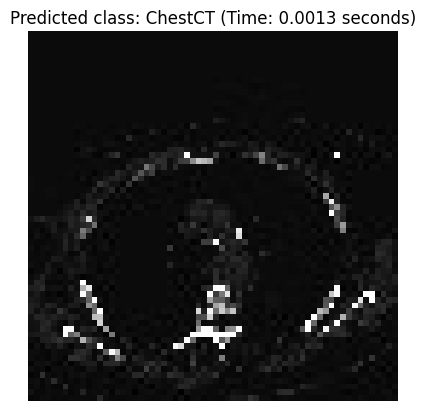

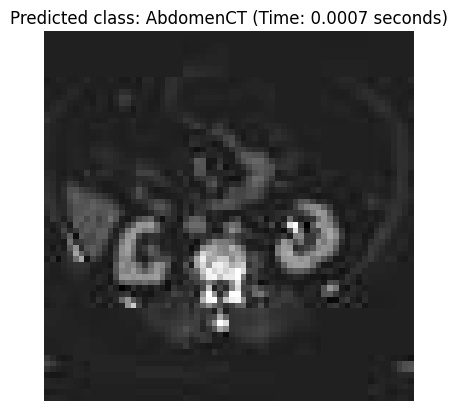

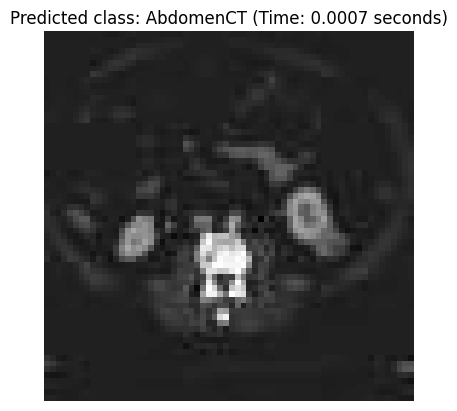

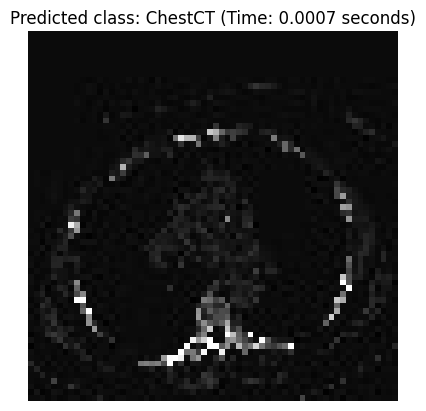

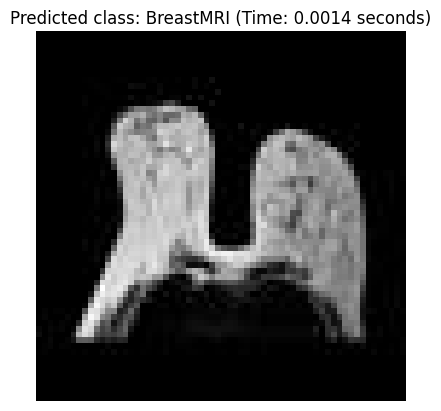

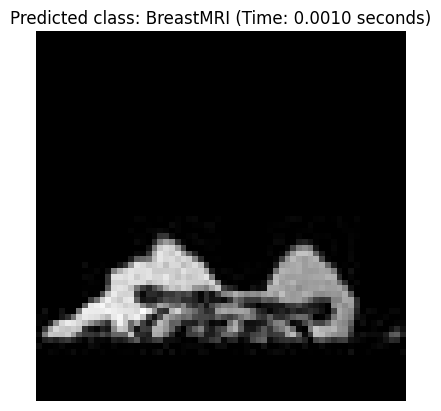

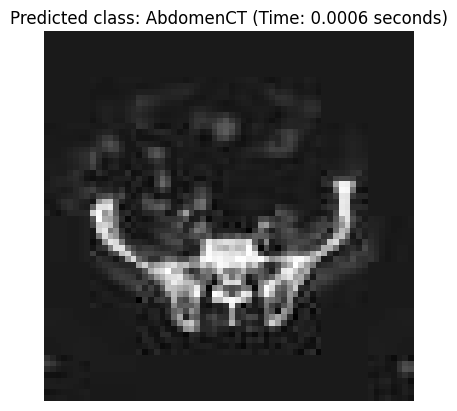

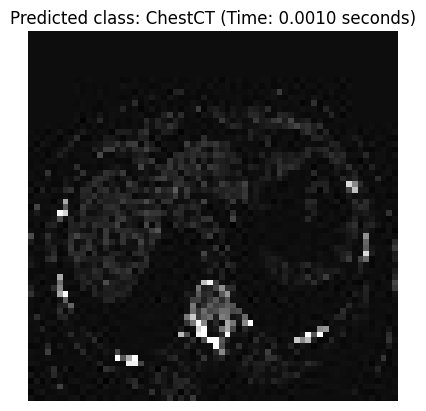

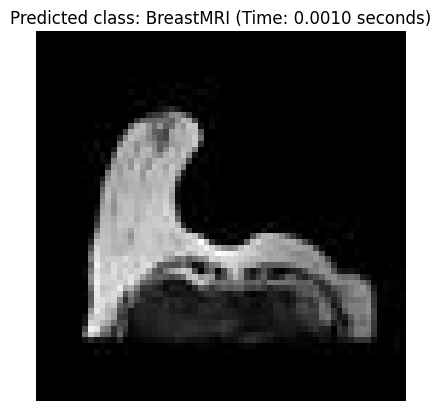

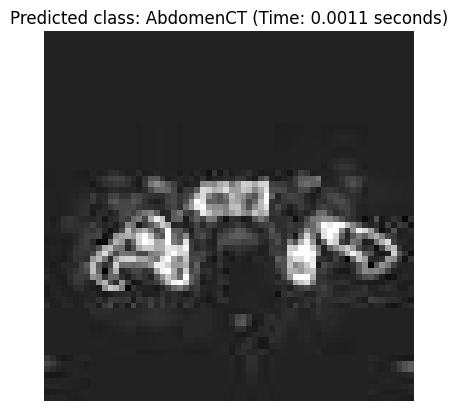

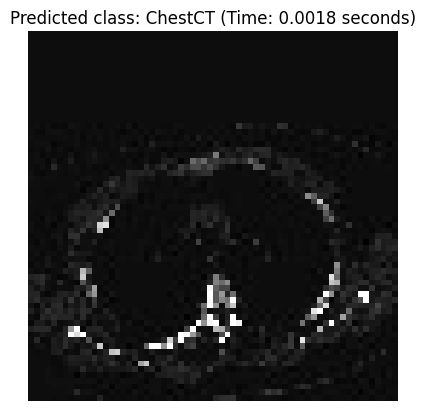

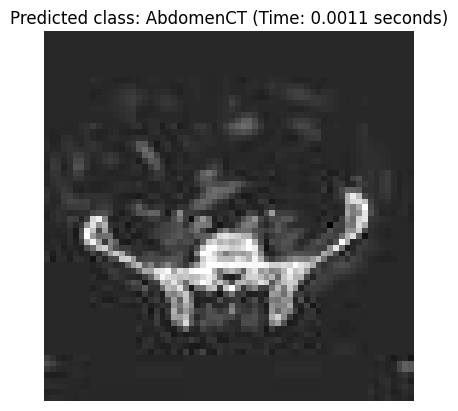

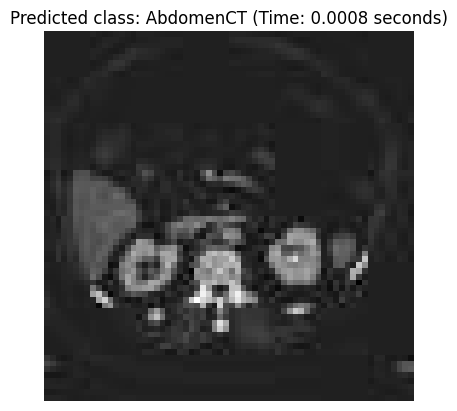

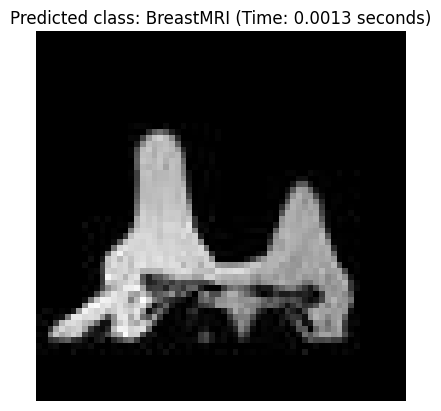

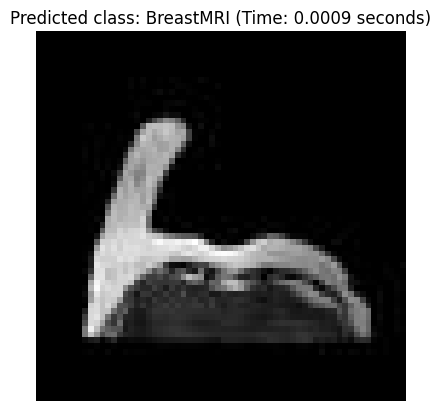

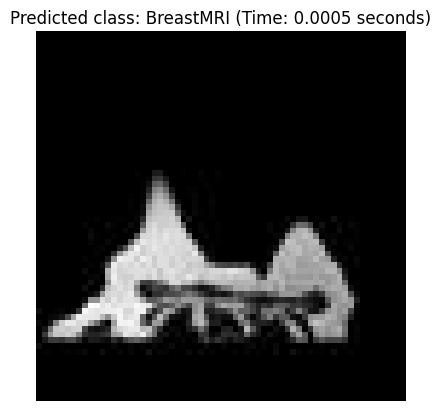

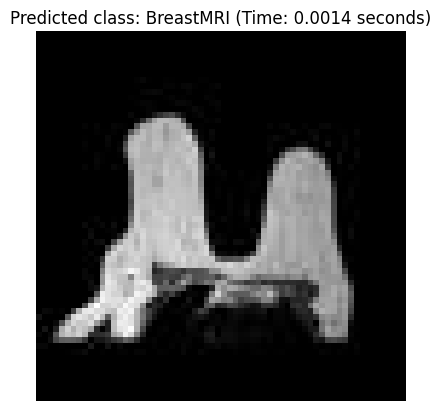

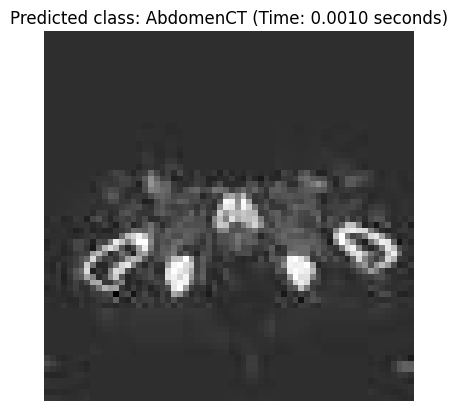

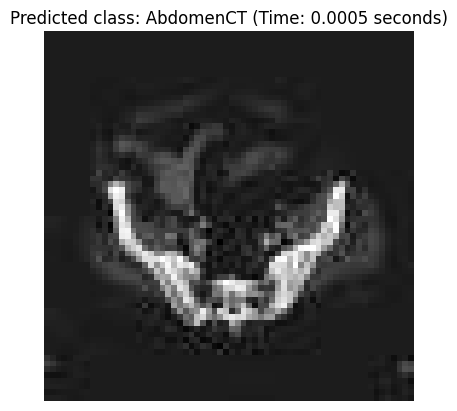

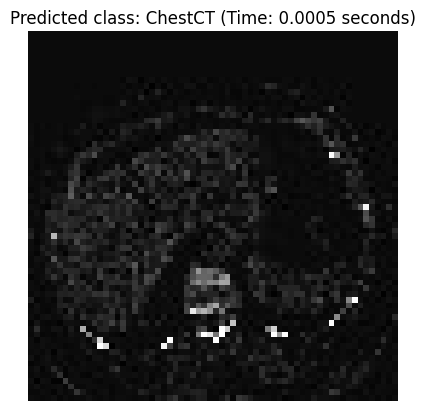

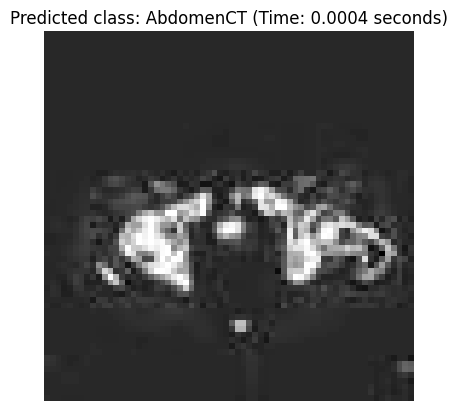

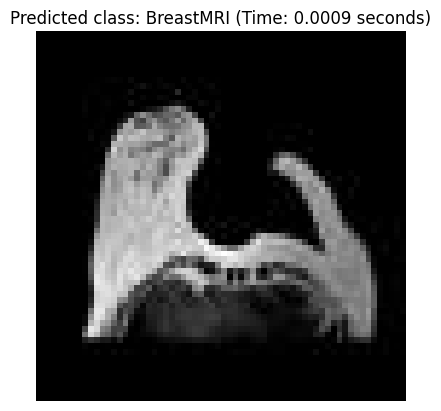

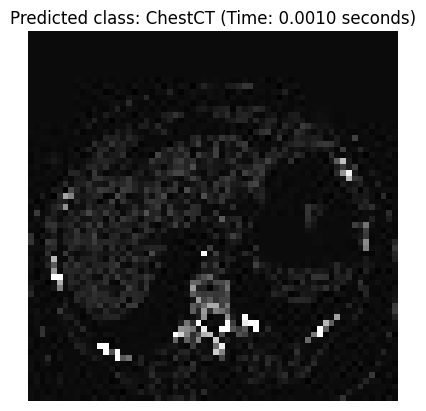

In [14]:
import time
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch

# 定义模型并加载权重
model_path = '/Users/huangweijin/Downloads/test_data/simple_cnn_model.pth'
model = SimpleCNN()  
model.load_state_dict(torch.load(model_path))
model.to(device) 

# 模型预测
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('L')  # 转换为灰度图
    image = transform(image)
    image = image.unsqueeze(0)  # 增加一个维度
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    return dataset.classes[predicted_class.item()]

def predict_images_folder(folder_path, model, transform):
    predictions = []
    image_paths = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_path = os.path.join(folder_path, filename)
            image_paths.append(image_path)

            # 开始计时
            start_time = time.time()
            predicted_class = predict_image(image_path, model, transform)
            end_time = time.time()

            predictions.append((image_path, predicted_class, end_time - start_time))

    return predictions

# 使用 predict_images_folder 函数
batch_predict_folder = '/Users/huangweijin/Downloads/题目一模型验证图片'
batch_predictions = predict_images_folder(batch_predict_folder, model, transform)

# 显示每张图像的预测结果
for image_path, prediction, duration in batch_predictions:
    img = Image.open(image_path)
    plt.imshow(img, cmap='gray')  # 显示为灰度图
    plt.title(f'Predicted class: {prediction} (Time: {duration:.4f} seconds)')
    plt.axis('off')
    plt.show()
